# Supermarket Problemi #
Bu eğitimde, daha önceki Makarna Üretim Problemine benzer olarak, yine IBM tarafından hazırlanan Supermarket Problemini çözeceğiz. Bu problem ile ilgili herhangi bir notebook olmadığı için bu notebooku kendimiz hazırlayacağzı. Bakalım IBM'in hazırladıkları kadar güzel olacak mı? Haydi o zaman başlayalım


## Problem ##
Bir süpermarketimiz var ve biz bu süpermarketin yetkili müdürüyüz. Görevimiz hangi ürünlerin hangi raflara yerleştirileceğine karar vermek. Kolay olan elimize gelen ürünü rafa koymak fakat biz optimizasyon bilen bir müdür olduğumuz için bu işi matematik ile çözmek istiyoruz. 

Ürünlerimiz ve raflarımız var. <br>
__Ürünlerimiz :__ Tavuk kanadı, domates sosu, salam, pirinç, makarna ve soya sosu.<br>
__Raflarımız :__ Super Promo, promo ve standart. Bu raflar da kendi içinde ikiye ayrılıyor. Soğutma özelliği olanlar ve olmayanlar.

Her bir ürünümüzün kar marjı, hacmi, buzdolabına ihtiyacı olup olmadığı, minumum ve maksimum adetleri verilmiş.<br>
Her bir rafın hacmi, soğuk saklama özelliği olup olmaması ve satış arttırma özelliği olup olmaması özellikleri verilmiş.<br>

__Amacımız__ bu bilgileri kullanarak, hangi ürünü hangi rafta sergilememiz gerektiğine karar vereceğiz. Bunu yaparken de en yüksek kar marjını elde etmeyi hedefleyeceğiz.

__Kısıtlarımız :__ Hacminden büyük alanda sergilenememek, buzdolabına ihtiyacı olan ürünlerin soğuk saklama özelliği olan raflarda sergilenmek. Bu kadar. 
<br>
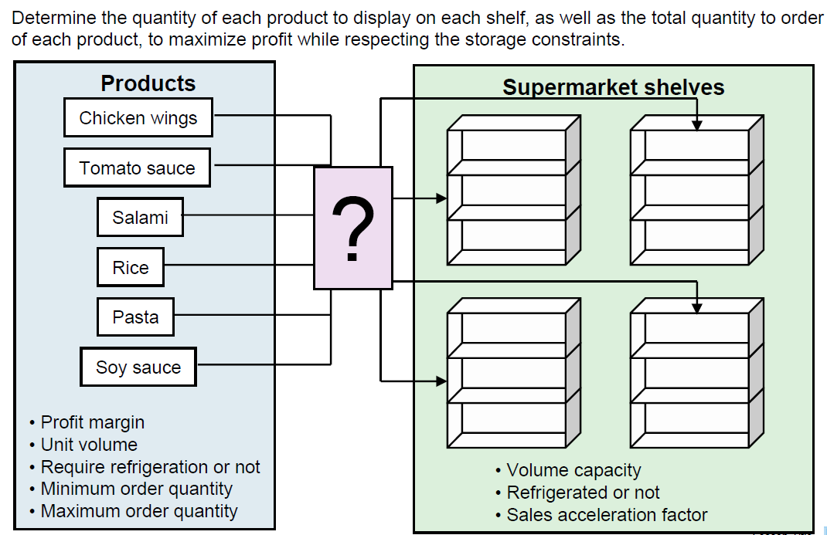

<br> 
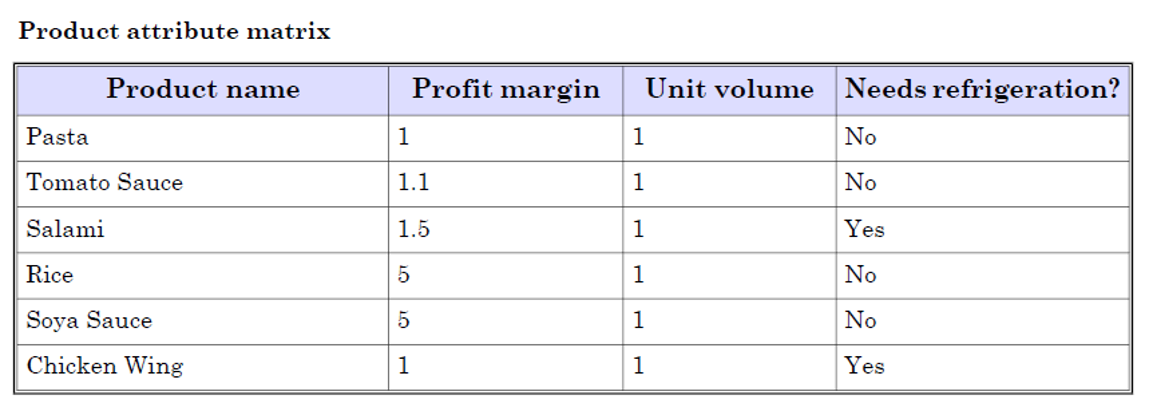

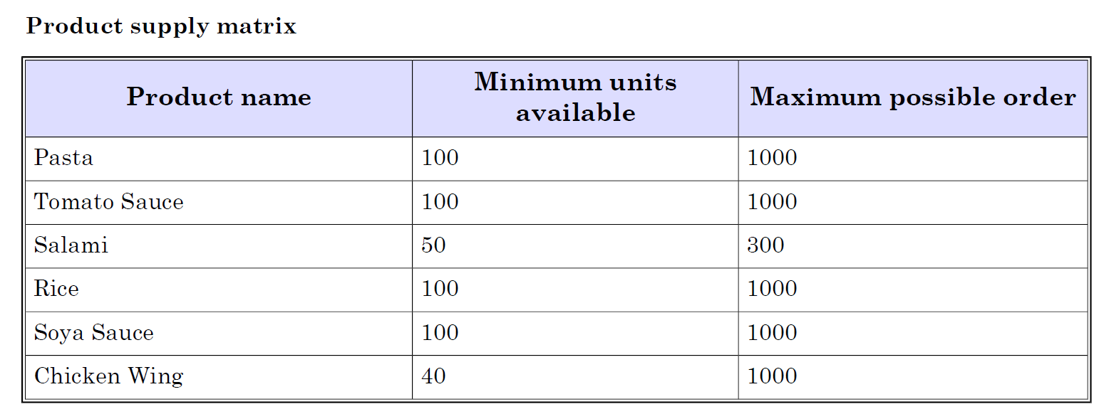

## DOcplex ile çözüm ##
__Kütüphaneler__

In [4]:
import cplex
import docplex.mp
import pandas as pd

__Data__<br>
Yukarıda tablolarda verilen değerleri veri yapılarına alıyoruz. Veriyi daha iyi yönetebilmek adına Pandas kullanacağız. Dataframe almak için önce dictionary formatında verileri manuel olarak yazdık. Ardından bu dictionaryleri Pandas Dataframelerine aktardık.

In [162]:
Products = {
    "productName": ["Pasta", "Tomato Sauce","Salami", "Rice", "Soya Sauce", "Chicken Wing"],
    "margin": [1, 1.1, 1.5, 5, 5, 1],
    "unitVolume": [1, 1, 1, 1, 1, 1],
    "isCold": [0, 0, 1, 0, 0, 1]
    
}

Supplies = {
    "productName": ["Pasta", "Tomato Sauce","Salami", "Rice", "Soya Sauce", "Chicken Wing"],
    "minStock": [100, 100, 50, 100, 100, 40],
    "maxStock": [1000, 1000, 300, 1000, 1000, 1000]
}

Shelves = {
    "shelf": ["SuperPromoFridge", "StandardShelf", "PromoFridge", "PromoShelf", "StandardFridge", "SuperPromoShelf"],
    "volumeCapacity": [100, 1000, 100, 1000, 100, 1000],
    "promAcc": [1.5, 0.5, 1, 1, 0.5, 1.5],
    "isCold": [1, 0, 1, 0, 1, 0]
}


In [163]:
df_products = pd.DataFrame(Products)
df_supplies = pd.DataFrame(Supplies)
df_shelves = pd.DataFrame(Shelves)

Veri yapılarını oluşturduktan sonra en son adım bu veri yapılarından bir veri yapısı daha oluşturuyoruz. Hangi ürünün hangi rafta sergilenebileceği bilgisini de bir dataframe aktarıyoruz. 

In [167]:
df_compabilityX = pd.merge(df_products, df_shelves, how='inner', on = 'isCold')

In [168]:
df_compability = df_compabilityX[["productName","shelf"]]

In [279]:
compabilityList = list(df_compability.itertuples(index=False, name=None))
productList = list(df_products.itertuples(index=False, name=None))
shelfList = list(df_shelves.itertuples(index=False, name=None))
supplyList = list(df_supplies.itertuples(index=False, name=None))

__Modelin Kurulması__

In [308]:
from docplex.mp.model import Model
mdl = Model(name="supermarket")

__Karar değişkenlerinin tanımlanması__<br>
Bir tane karar değişkenimiz bulunuyor. Hangi ürünün hangi rafta ne kadar sergileneceği. En son oluşturduğumuz __Compability__ veri yapısını kullanarak bu karar değişkenini oluşturuyoruz.

In [309]:
stored_quantity = mdl.continuous_var_dict(compabilityList, name='storedQty', lb=0)

__Kısıtların yazılması__<br>
3 tane kısıtımız bulunuyor. <br>
<ul>
    <li>Her bir ürün için belirlenen minumum stok miktarını geçmemeiz gerekiyor.</li>
    <li>Her bir ürün için belirlenen maksimum stok miktarını geçmemeiz gerekiyor.</li>
    <li>Her bir rafın kapasitesinin aşılmaması gerekiyor. </li>
</ul>



In [311]:
compabilityList

[('Pasta', 'StandardShelf'),
 ('Pasta', 'PromoShelf'),
 ('Pasta', 'SuperPromoShelf'),
 ('Tomato Sauce', 'StandardShelf'),
 ('Tomato Sauce', 'PromoShelf'),
 ('Tomato Sauce', 'SuperPromoShelf'),
 ('Rice', 'StandardShelf'),
 ('Rice', 'PromoShelf'),
 ('Rice', 'SuperPromoShelf'),
 ('Soya Sauce', 'StandardShelf'),
 ('Soya Sauce', 'PromoShelf'),
 ('Soya Sauce', 'SuperPromoShelf'),
 ('Salami', 'SuperPromoFridge'),
 ('Salami', 'PromoFridge'),
 ('Salami', 'StandardFridge'),
 ('Chicken Wing', 'SuperPromoFridge'),
 ('Chicken Wing', 'PromoFridge'),
 ('Chicken Wing', 'StandardFridge')]

In [312]:
for p in productList:
    for s in supplyList:
        mdl.add_constraints(mdl.sum(stored_quantity[c] for c in compabilityList if(p[0]==c[0] and s[0]==c[0])) 
                            >= s[1] for s in supplyList if(p[0]==s[0]))

In [313]:
for p in productList:
    for s in supplyList:
        mdl.add_constraints(mdl.sum(stored_quantity[c] for c in compabilityList if(p[0]==c[0] and s[0]==c[0]))  
                            <= s[2] for s in supplyList if(p[0]==s[0]))

In [317]:
for sh in shelfList:
    mdl.add_constraints(mdl.sum(stored_quantity[c] * p[2] for c in compabilityList for p in productList
                                if(c[1]==sh[0] and c[0]==p[0])) 
                        <= sh[1] for sh in shelfList)

Şu ana kadar modelimizin durumunu sorgulayalım.


In [318]:
mdl.print_information()

Model: supermarket
 - number of variables: 18
   - binary=0, integer=0, continuous=18
 - number of constraints: 108
   - linear=108
 - parameters: defaults
 - objective: none
 - problem type is: LP


__Amaç Fonksiyonu__<br>
Amacımız karı maksimize etmektir. Bunu yapmak için öncelike bir KPI oluşturuyoruz. Sonrasında bu KPI maksimize edecek amaç fonksiyonunu yazıyoruz.

In [319]:
profitKPI = mdl.sum(stored_quantity[c] * sh[2] * p[1] for c in compabilityList 
                 for sh in shelfList 
                 for p in productList if(c[1]==sh[0] and c[0]==p[0]))

In [320]:
mdl.add_kpi(profitKPI, publish_name="KPI.Profit")

DecisionKPI(name=KPI.Profit,expr=0.500storedQty_Pasta_StandardShelf+storedQty_Pasta_PromoShelf+1...)

In [321]:
mdl.maximize(profitKPI)

__Modelin Çözümü__<br>
Modeli çözmek için __Model.solve()__ fonksiyonunu çalıştırıyoruz.

In [322]:
mdl.solve()

docplex.mp.solution.SolveSolution(obj=13485,values={storedQty_Pasta_Stan..

In [333]:
obj = mdl.objective_value

print("* Amaç Fonksiyonu Sonucu : {:g}".format(obj))
print("* Toplam Kar=%g" % profitKPI.solution_value)
for c in compabilityList:
    print("Sergilenen Ürün Miktarı {compabilityList}: {ins_var}".format(compabilityList=c[0], ins_var=stored_quantity[c].solution_value))



* Amaç Fonksiyonu Sonucu : 13485
* Toplam Kar=13485
Sergilenen Ürün Miktarı Pasta: 100.0
Sergilenen Ürün Miktarı Pasta: 0
Sergilenen Ürün Miktarı Pasta: 0
Sergilenen Ürün Miktarı Tomato Sauce: 900.0
Sergilenen Ürün Miktarı Tomato Sauce: 0
Sergilenen Ürün Miktarı Tomato Sauce: 0
Sergilenen Ürün Miktarı Rice: 0
Sergilenen Ürün Miktarı Rice: 0
Sergilenen Ürün Miktarı Rice: 1000.0
Sergilenen Ürün Miktarı Soya Sauce: 0
Sergilenen Ürün Miktarı Soya Sauce: 1000.0
Sergilenen Ürün Miktarı Soya Sauce: 0
Sergilenen Ürün Miktarı Salami: 100.0
Sergilenen Ürün Miktarı Salami: 100.0
Sergilenen Ürün Miktarı Salami: 60.0
Sergilenen Ürün Miktarı Chicken Wing: 0
Sergilenen Ürün Miktarı Chicken Wing: 0
Sergilenen Ürün Miktarı Chicken Wing: 40.0


In [323]:
mdl.print_solution()

objective: 13485.000
  "storedQty_Pasta_StandardShelf"=100.000
  "storedQty_Tomato Sauce_StandardShelf"=900.000
  "storedQty_Rice_SuperPromoShelf"=1000.000
  "storedQty_Soya Sauce_PromoShelf"=1000.000
  "storedQty_Salami_SuperPromoFridge"=100.000
  "storedQty_Salami_PromoFridge"=100.000
  "storedQty_Salami_StandardFridge"=60.000
  "storedQty_Chicken Wing_StandardFridge"=40.000


Supermarket probleminin de sonuna geldik. Bu problemde, farklı kümelerdeki verilerle kısıt yazmayı öğrendik. Sonucunda modelimizi tamamladık. Bir sonraki derste görüşmek üzere.

__Sabri Suyunu__